## **Step 1: Importing the Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Step 2: Load datasets**

In [5]:
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

## **Step 3: Convert timestamps and align by date**

In [6]:
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")
trader_df['date'] = trader_df['Timestamp IST'].dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

## **Step 4: Merge datasets**

In [7]:
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='inner')

###  **Analysis 1 : Correlation Between Sentiment Value and Closed PnL**

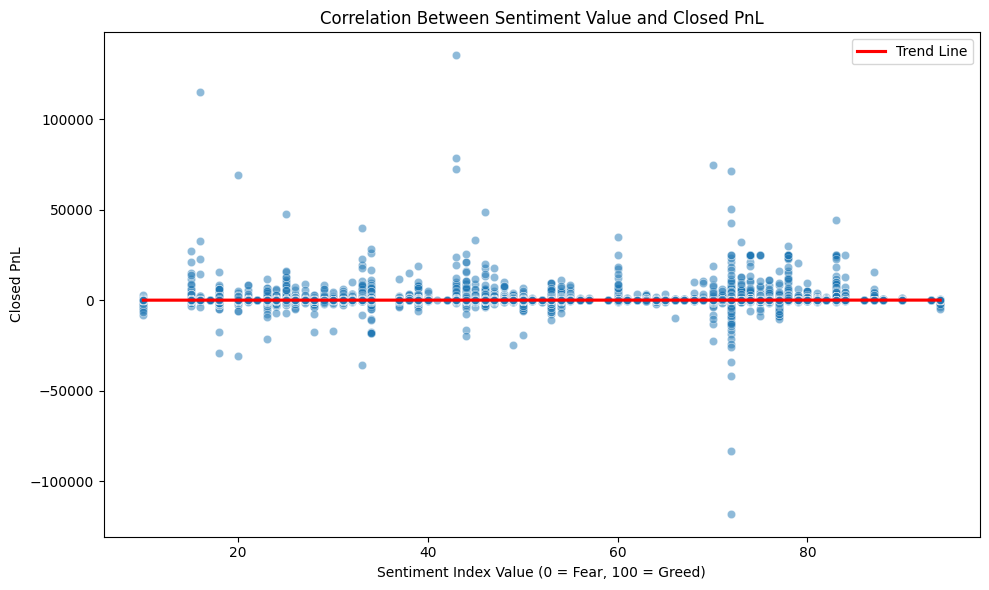

In [8]:
# Plot: Sentiment value vs Closed PnL
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='value', y='Closed PnL', alpha=0.5)
sns.regplot(data=merged_df, x='value', y='Closed PnL', scatter=False, color='red', label='Trend Line')

plt.title('Correlation Between Sentiment Value and Closed PnL')
plt.xlabel('Sentiment Index Value (0 = Fear, 100 = Greed)')
plt.ylabel('Closed PnL')
plt.legend()
plt.tight_layout()
plt.show()

### **Analysis 2 : Account-Level Performance Under Different Sentiments**

In [9]:
# Group by account and sentiment to compute average PnL
account_sentiment_pnl = merged_df.groupby(['Account', 'classification'])['Closed PnL'].mean().reset_index()

In [15]:
# (Optional) Filter top N accounts by number of trades to simplify the chart
top_accounts = merged_df['Account'].value_counts().nlargest(10).index
filtered_df = account_sentiment_pnl[account_sentiment_pnl['Account'].isin(top_accounts)]

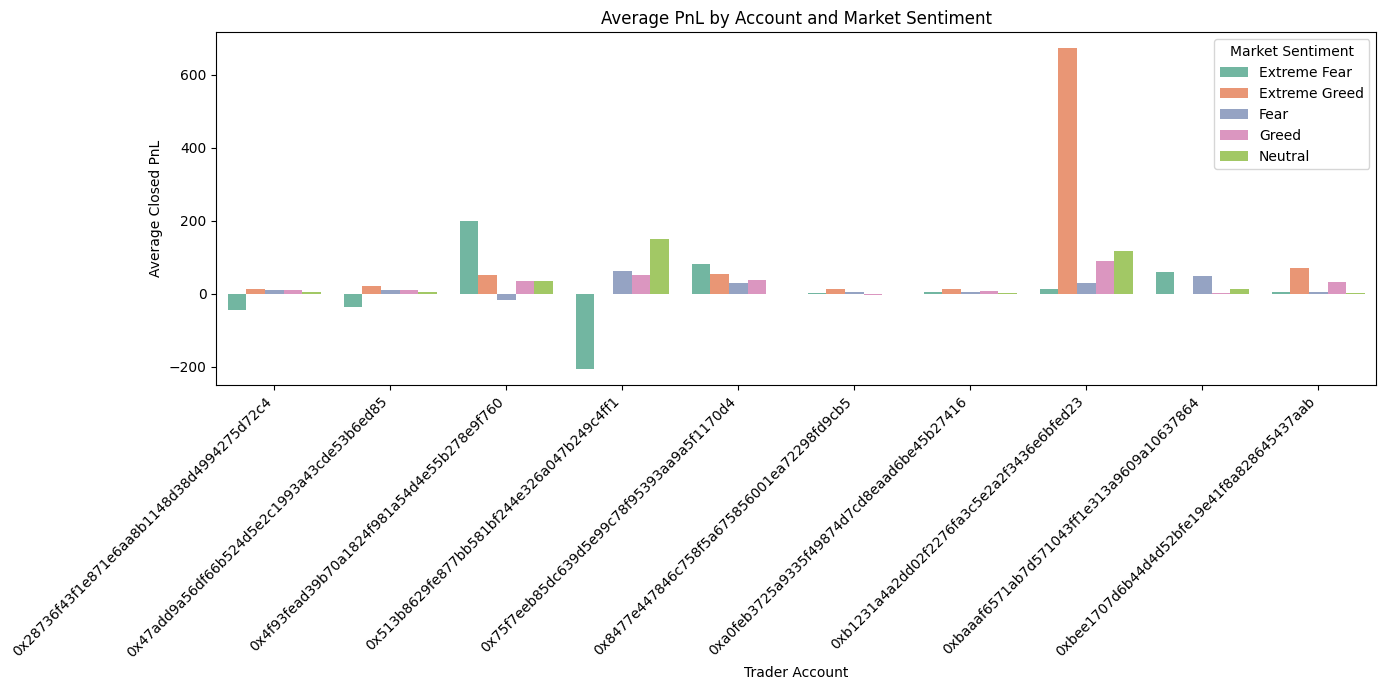

In [16]:
# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=filtered_df, x='Account', y='Closed PnL', hue='classification', palette='Set2')
plt.title('Average PnL by Account and Market Sentiment')
plt.xlabel('Trader Account')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=45, ha='right')  # align tick labels better
plt.legend(title='Market Sentiment')
plt.tight_layout()
plt.show()


## **Analysis 3 : PnL Trends Over Time with Sentiment**

In [18]:
# Aggregate daily total PnL
daily_pnl = merged_df.groupby(['date', 'classification'])['Closed PnL'].sum().reset_index()

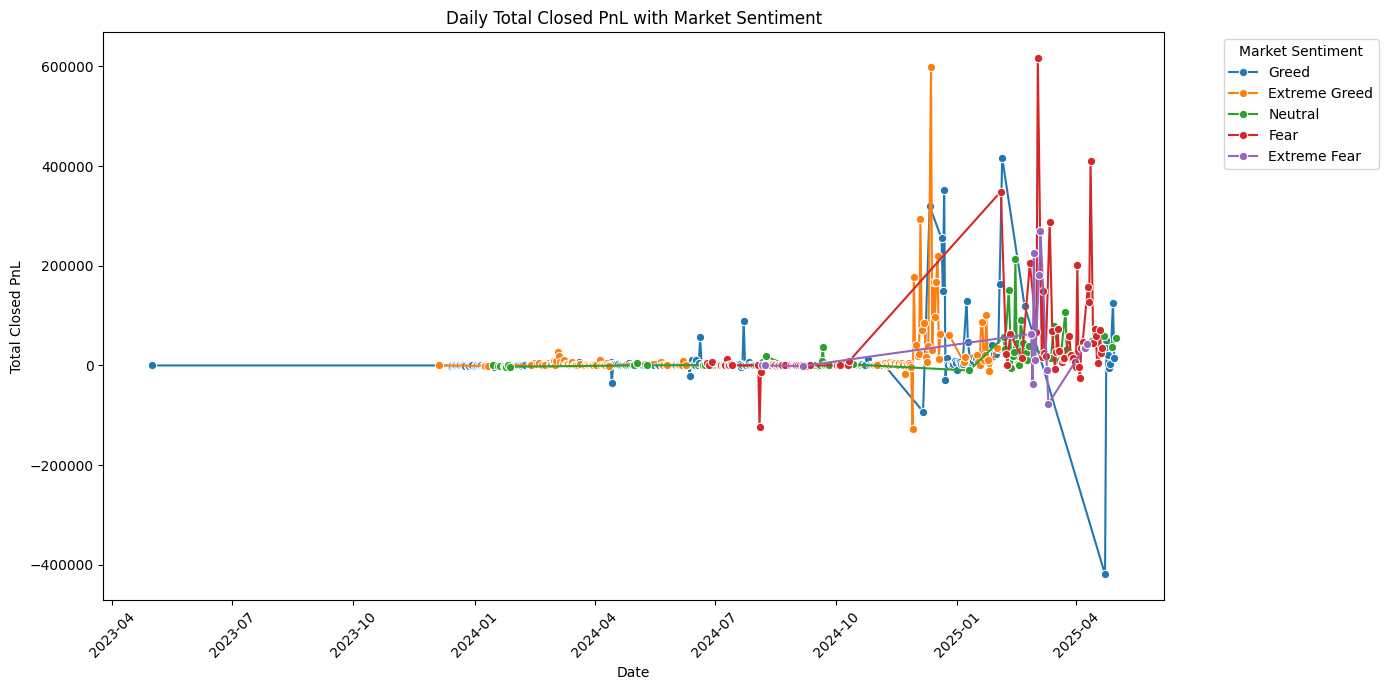

In [19]:
# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_pnl, x='date', y='Closed PnL', hue='classification', marker='o')

plt.title('Daily Total Closed PnL with Market Sentiment')
plt.xlabel('Date')
plt.ylabel('Total Closed PnL')
plt.xticks(rotation=45)
plt.legend(title='Market Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## **Analyse 4 : Trade Size vs PnL**

In [20]:
# Filter out extreme trade sizes (optional to reduce noise)
merged_df = merged_df[(merged_df['Size USD'] > 0) & (merged_df['Size USD'] < merged_df['Size USD'].quantile(0.99))]

<Figure size 1200x700 with 0 Axes>

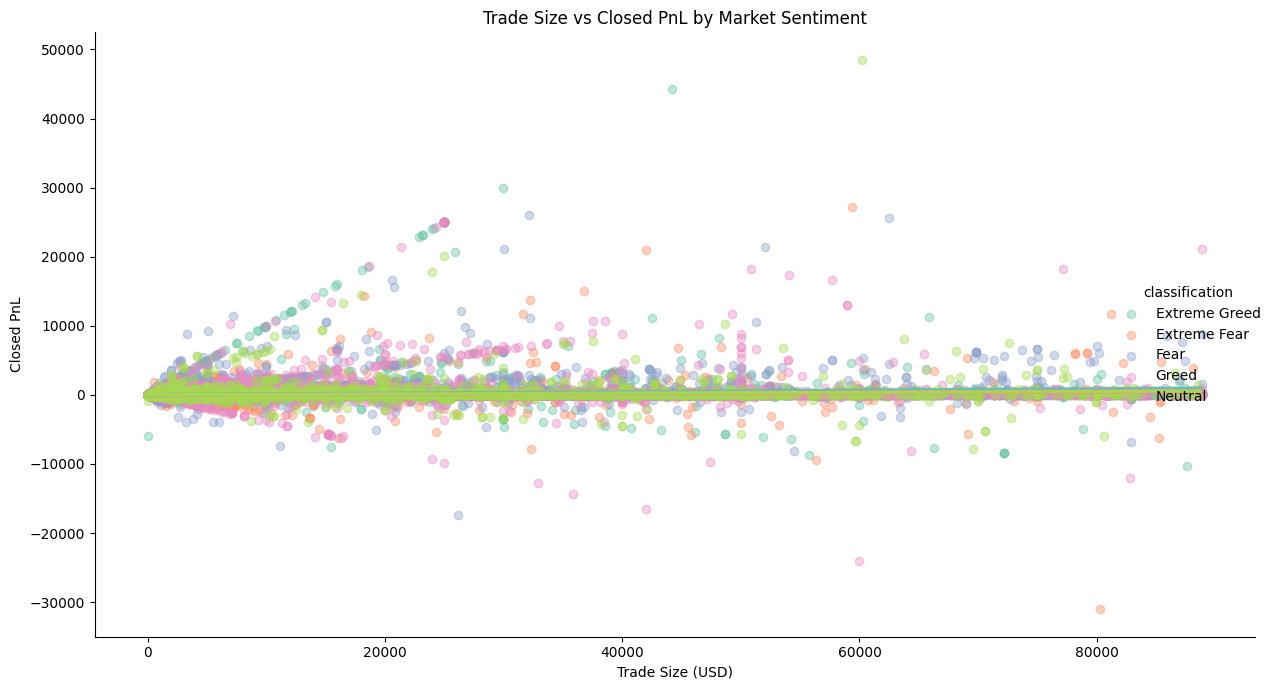

In [21]:
# Plot regression of trade size vs PnL, segmented by sentiment
plt.figure(figsize=(12, 7))
sns.lmplot(
    data=merged_df,
    x='Size USD',
    y='Closed PnL',
    hue='classification',
    scatter_kws={'alpha': 0.4},
    height=7,
    aspect=1.6,
    palette='Set2'
)

plt.title('Trade Size vs Closed PnL by Market Sentiment')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Closed PnL')
plt.tight_layout()
plt.show()

## **Analyse 5 : Win Rate by Sentiment**

In [22]:
# Define a win (Closed PnL > 0)
merged_df['is_win'] = merged_df['Closed PnL'] > 0

In [23]:
# Group by sentiment and calculate win rate
win_rate_df = merged_df.groupby('classification')['is_win'].mean().reset_index()
win_rate_df['win_rate_percent'] = win_rate_df['is_win'] * 100

C:\Users\Admin\AppData\Local\Temp\ipykernel_5908\950341569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_rate_df, x='classification', y='win_rate_percent', palette='coolwarm')


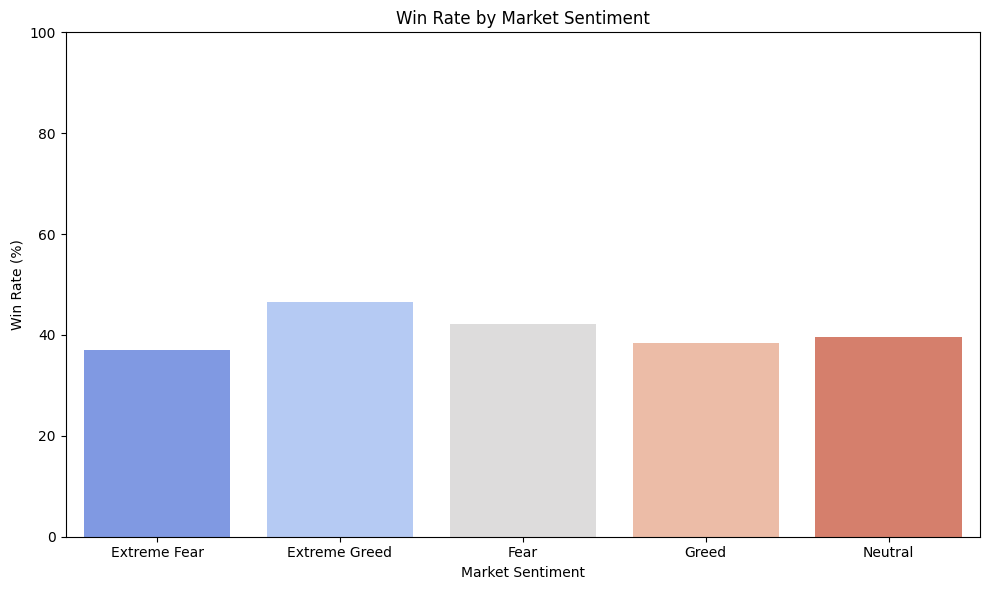

In [24]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=win_rate_df, x='classification', y='win_rate_percent', palette='coolwarm')

plt.title('Win Rate by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


## **Analyse 6 : Volatility by Sentiment (PnL Std Dev per Day)**

In [27]:
# Compute daily standard deviation of Closed PnL
daily_std = merged_df.groupby(['date'])['Closed PnL'].std().reset_index()
daily_std.columns = ['date', 'pnl_std']

In [28]:
# Merge back to sentiment
volatility_df = pd.merge(daily_std, sentiment_df[['date', 'classification']], on='date', how='left')

In [29]:
# Drop NA std values (days with 1 trade only)
volatility_df = volatility_df.dropna(subset=['pnl_std'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_5908\3978364298.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=volatility_df, x='classification', y='pnl_std', palette='pastel')


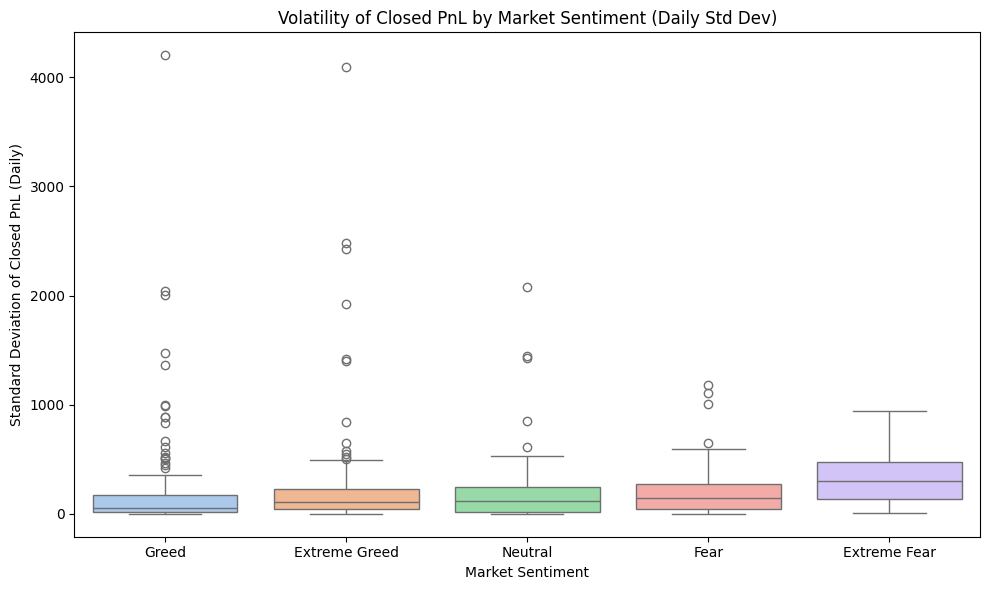

In [30]:
# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=volatility_df, x='classification', y='pnl_std', palette='pastel')

plt.title('Volatility of Closed PnL by Market Sentiment (Daily Std Dev)')
plt.xlabel('Market Sentiment')
plt.ylabel('Standard Deviation of Closed PnL (Daily)')
plt.tight_layout()
plt.show()